# MLADS 2019 - Deep Learning for NLP Applications: Part 4

# Using Pretrained FastText Embeddings with CNN's for Text Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.datasets import imdb

Using TensorFlow backend.


### Load and preprocess the data

In [2]:
'''
Load the data as a list of integers
'''

maxlen = 400
max_features = 5000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


Loading data...


### Fast Text Embeddings

- We will use pretrained FastText embeddings here (https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip) 
- Pretrained on Wikipedia Corpus (2017) and the statmt.org news dataset
- 300 dimensional embeddings with 1 M word vectors


#### The embeddings can be downloaded from https://fasttext.cc/docs/en/english-vectors.html

### Embedding Format
The first line of the file contains the number of words in the vocabulary and the size of the vectors. Each line contains a word followed by its vectors, like in the default fastText text format. Each value is space separated. Words are ordered by descending frequency. These text models can easily be loaded in Python using the following code:

In [3]:
from tqdm import tqdm
import codecs
import numpy as np


print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


999995it [03:10, 5254.61it/s]


found 999995 word vectors


### Inspect the embeddings

In [4]:
count = 0
for key, val in embeddings_index.items():
    print(key, "==>", val)
    print(len(val))
    count = count + 1
    if (count > 1):
        break

Cerita ==> [ -4.01000008e-02  -2.67999992e-02  -1.15400001e-01  -7.60999992e-02
  -1.66099995e-01   4.34000008e-02  -3.46999988e-02   3.70999984e-02
  -1.84100002e-01   1.25499994e-01   1.10999998e-02   9.49999969e-03
  -3.51000018e-02  -2.70000007e-03   3.66999991e-02   7.15000033e-02
   2.52000000e-02  -1.31200001e-01   1.55999996e-02  -1.29400000e-01
  -4.12999988e-02  -1.80099994e-01   3.29999998e-03  -8.89999978e-03
   8.54000002e-02  -1.51800007e-01   4.83999997e-02   5.18000014e-02
   5.79999983e-02   9.08999965e-02  -1.27200007e-01  -3.57000008e-02
   7.00000022e-03  -7.03999996e-02   6.06999993e-02  -6.17000014e-02
   9.27999988e-02  -8.34999979e-02  -8.63000005e-02  -1.05200000e-01
   1.43999994e-01  -7.10999966e-02  -4.39000018e-02  -1.15300000e-01
   1.12999998e-01  -3.37000005e-02   1.48999998e-02  -3.24999988e-02
   1.63000003e-02  -1.74000002e-02   1.00800000e-01  -1.16599999e-01
  -9.03599977e-01  -5.26000001e-02  -8.26999992e-02   3.18999998e-02
   4.30000015e-02   1.1

### Set the parameters for training

In [12]:
#training params
max_features = 5000
batch_size = 256 
num_epochs = 8 


#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4
kernel_size=3
hidden_dims = 250

### Prepare the embedding matrix for the IMDB dataset 

In [6]:
#embedding matrix
word_index = imdb.get_word_index()
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 106


In [7]:
print(embedding_matrix.shape)
print("sample words not found: ", np.random.choice(words_not_found, 20))

(5000, 300)
sample words not found:  ["won't" "90's" "show's" "it's" 'branagh' 'lugosi' 'walken' 'carradine'
 "children's" "80's" "won't" "hollywood's" 'carradine' "1950's"
 "everyone's" 'lumet' "year's" "they've" "i'll" "year's"]


### Define the CNN architecture

In [16]:
#CNN architecture
print("training CNN ...")
model = Sequential()

# specify that we are freezing the embedding layer
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(num_filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))

model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 300)          1500000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 398, 64)           57664     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               16250     
_________________________________________________________________
activation_3 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0   

### Train the model

In [17]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
25000/25000 [==============================] - 2s 91us/step - loss: 0.6288 - acc: 0.6502 - val_loss: 0.4735 - val_acc: 0.7800
Epoch 2/8
25000/25000 [==============================] - 2s 70us/step - loss: 0.3963 - acc: 0.8245 - val_loss: 0.3743 - val_acc: 0.8322
Epoch 3/8
25000/25000 [==============================] - 2s 68us/step - loss: 0.2963 - acc: 0.8765 - val_loss: 0.3867 - val_acc: 0.8257
Epoch 4/8
25000/25000 [==============================] - 2s 68us/step - loss: 0.2344 - acc: 0.9089 - val_loss: 0.3750 - val_acc: 0.8371
Epoch 5/8
25000/25000 [==============================] - 2s 70us/step - loss: 0.1887 - acc: 0.9312 - val_loss: 0.3467 - val_acc: 0.8516
Epoch 6/8
25000/25000 [==============================] - 2s 71us/step - loss: 0.1403 - acc: 0.9560 - val_loss: 0.3558 - val_acc: 0.8527
Epoch 7/8
25000/25000 [==============================] - 2s 71us/step - loss: 0.1022 - acc: 0.9717 - val_loss: 0.4064 - val_acc: 0.841

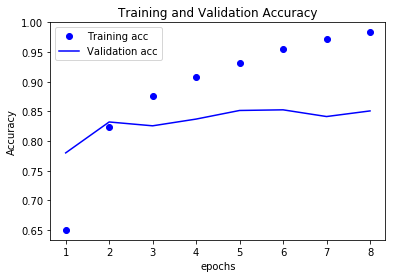

In [18]:
%matplotlib inline
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 2s 81us/step


[0.40613121783256528, 0.85084000000000004]